# Baseline but faster

I copied functions from other notebooks and made them 5-10 times **faster**.

**My contribution:**
* All configurations and paths are now `numpy` arrays instead of lists of tuples.
* Using `numba.njit` to compile those functions.
* Made baseline score a little better
* Path visualization

**Sources:**
* Baseline solution from: [TSP - Cost Function Start+Compress Path+Split](https://www.kaggle.com/code/asalhi/tsp-cost-function-start-compress-path-split)
* Visualization from: [Lower Bound using Minimum Spanning Tree](https://www.kaggle.com/code/cnumber/lower-bound-using-minimum-spanning-tree)

More info on Numba acceleration in my [discussions post](https://www.kaggle.com/competitions/santa-2022/discussion/371194).

## Some useful functions

&#8595; &#8595; &#8595; &#8595; &#8595; &#8595; &#8595; Function are hidden below &#8595; &#8595; &#8595; &#8595; &#8595; &#8595; &#8595;

In [1]:
import matplotlib.pyplot as plt
import matplotlib.collections as mc
import numpy as np
import pandas as pd
from functools import *
from itertools import *
from pathlib import Path
from PIL import Image
from tqdm import tqdm, trange
import cv2
import numba as nb

plt.style.use('seaborn-whitegrid')



# Functions to map between cartesian coordinates and array indexes
@nb.njit
def cartesian_to_array(x, y, shape):
    m, n = shape[:2]
    i = (n - 1) // 2 - y
    j = (n - 1) // 2 + x
    if i < 0 or i >= m or j < 0 or j >= n:
        raise ValueError("Coordinates not within given dimensions.")
    return i, j

@nb.njit
def array_to_cartesian(i, j, shape):
    m, n = shape[:2]
    if i < 0 or i >= m or j < 0 or j >= n:
        raise ValueError("Coordinates not within given dimensions.")
    y = (n - 1) // 2 - i
    x = j - (n - 1) // 2
    return x, y


point = (1, 8)
shape = (9, 9, 3)
assert cartesian_to_array(*array_to_cartesian(*point, shape), shape) == point


# Functions to map an image between array and record formats
def image_to_dict(image):
    image = np.atleast_3d(image)
    kv_image = {}
    for i, j in product(range(len(image)), repeat=2):
        kv_image[array_to_cartesian(i, j, image.shape)] = tuple(image[i, j])
    return kv_image


def image_to_df(image):
    return pd.DataFrame(
        [(x, y, r, g, b) for (x, y), (r, g, b) in image_to_dict(image).items()],
        columns=['x', 'y', 'r', 'g', 'b']
    )


def df_to_image(df):
    side = int(len(df) ** 0.5)  # assumes a square image
    return df.set_index(['x', 'y']).to_numpy().reshape(side, side, -1)


def imread(path):
    if isinstance(path, Path):
        path = path.as_posix()
    return cv2.imread(path)[:, :, ::-1] / 255


@nb.njit
def get_position(config):
    return config.sum(0)

@nb.njit
def rotate_link(vector, direction):
    x, y = vector
    if direction == 1:  # counter-clockwise
        if y >= x and y > -x:
            x -= 1
        elif y > x and y <= -x:
            y -= 1
        elif y <= x and y < -x:
            x += 1
        else:
            y += 1
    elif direction == -1:  # clockwise
        if y > x and y >= -x:
            x += 1
        elif y >= x and y < -x:
            y += 1
        elif y < x and y <= -x:
            x -= 1
        else:
            y -= 1
    return (x, y)

@nb.njit
def rotate(config, i, direction):
    config = config.copy()
    config[i] = rotate_link(config[i], direction)
    return config


# compress a path between two points
@nb.njit
def compress_path(path):
    n_joints = path.shape[1]
    r = np.zeros((n_joints, path.shape[0], 2), dtype=path.dtype)
    l = np.zeros(n_joints, dtype='int')
    for j in range(len(path)):
        for i in range(n_joints):
            if l[i] == 0 or (r[i][l[i] - 1] != path[j, i]).any():
                r[i, l[i]] = path[j, i]
                l[i] += 1
    r = r[:, :l.max()]

    for i in range(n_joints):
        for j in range(l[i], r.shape[1]):
            r[i, j] = r[i, j - 1]
    r = r.transpose(1, 0, 2)

    return r


@nb.njit
def get_direction(u, v):
    """Returns the sign of the angle from u to v."""
    # direction = np.sign(np.cross(u, v))
    direction = np.sign(u[0] * v[1] - u[1] * v[0])
    if direction == 0 and (u * v).sum() < 0:
        direction = 1
    return direction


@nb.njit
def get_radius(config):
    r = 0
    for link in config:
        r += np.abs(link).max()
    return r

@nb.njit
def get_radii(config):
    radii = np.cumsum(np.maximum(np.abs(config[:, 0]), np.abs(config[:, 1]))[::-1])[::-1]
    return np.append(radii, np.zeros(1, dtype='int'))


@nb.njit
def get_path_to_point(config, point):
    """Find a path of configurations to `point` starting at `config`."""
    config_start = config.copy()
    radii = get_radii(config)

    # Rotate each link, starting with the largest, until the point can
    # be reached by the remaining links. The last link must reach the
    # point itself.
    for i in range(len(config)):
        link = config[i]
        base = get_position(config[:i])
        relbase = point - base
        position = get_position(config[:i+1])
        relpos = point - position
        radius = radii[i + 1]
        # Special case when next-to-last link lands on point. 
        if radius == 1 and (relpos == 0).all():
            config = rotate(config, i, 1)
            if (get_position(config) == point).all():
                break
            else:
                continue
        while np.max(np.abs(relpos)) > radius:
            direction = get_direction(link, relbase)
            config = rotate(config, i, direction)
            link = config[i]
            base = get_position(config[:i])
            relbase = point - base
            position = get_position(config[:i+1])
            relpos = point - position
            radius = get_radius(config[i + 1:])

    assert (get_position(config) == point).all()
    path = get_path_to_configuration(config_start, config)

    return path


@nb.njit
def get_path_to_configuration(from_config, to_config):
    path = np.expand_dims(from_config, 0).copy()
    config = from_config.copy()
    while (config != to_config).any():
        for i in range(len(config)):
            config = rotate(config, i, get_direction(config[i], to_config[i]))
        path = np.append(path, np.expand_dims(config, 0), 0)
    assert (path[-1] == to_config).all()
    return path


# Functions to compute the cost function

# Cost of reconfiguring the robotic arm: the square root of the number of links rotated
@nb.njit
def reconfiguration_cost(from_config, to_config):
    diffs = np.abs(np.asarray(from_config) - np.asarray(to_config)).sum(axis=1)
    assert diffs.max() <= 1
    return np.sqrt(diffs.sum())


# Cost of moving from one color to another: the sum of the absolute change in color components
@nb.njit
def color_cost(from_position, to_position, image, color_scale=3.0):
    return np.abs(image[to_position] - image[from_position]).sum() * color_scale


# Total cost of one step: the reconfiguration cost plus the color cost
@nb.njit
def step_cost(from_config, to_config, image):
    pos_from = get_position(from_config)
    pos_to = get_position(to_config)
    from_position = cartesian_to_array(pos_from[0], pos_from[1], image.shape)
    to_position = cartesian_to_array(pos_to[0], pos_to[1], image.shape)
    return (
        reconfiguration_cost(from_config, to_config) +
        color_cost(from_position, to_position, image)
    )

# Compute total cost of path over image
@nb.njit
def total_cost(path, image):
    cost = 0
    for i in range(1, len(path)):
        cost += step_cost(path[i - 1], path[i], image)
    return cost


def get_origin(size):
    assert size % 2 == 1
    radius = size // 2
    p = [1]
    for power in range(0, 8):
        p.append(2**power)
        if sum(p) == radius:
            break
    else:
        assert False
    p = p[::-1]
    config = np.array([(p[0], 0)] + [(-pp, 0) for pp in p[1:]])
    return config


def points_to_path(points, size=257):
    origin = get_origin(size)

    visited = set()
    path = [origin]
    for p in points:
        config = path[-1]
        if tuple(p) not in visited:
            candy_cane_road = get_path_to_point(config, p)[1:]
            if len(candy_cane_road) > 0:
                visited |= set([tuple(get_position(r)) for r in candy_cane_road])
            path.extend(candy_cane_road)
    # Back to origin
    candy_cane_road = get_path_to_configuration(path[-1], origin)[1:]
    visited |= set([tuple(get_position(r)) for r in candy_cane_road])
    path.extend(candy_cane_road)
    
    assert len(visited) == size**2, f'Visited {len(visited)} points out of {size**2}'
    
    return np.array(path)


@nb.njit
def dir2idx(dx, dy):
    assert dx >= -1 and dx <= 1 and dy >= -1 and dy <= 1
    assert not (dx == 0 and dy == 0)
    idx = (dx + 1) * 3 + dy + 1
    if idx > 4:
        idx = idx - 1
    return idx

@nb.njit
def idx2dir(idx):
    assert idx >= 0 and idx < 8
    if idx >= 4:
        idx = idx + 1
    dx = idx // 3 - 1
    dy = idx % 3 - 1
    return dx, dy

@nb.njit
def idx2newij(i, j, idx):
    dx, dy = idx2dir(idx)
    new_i = i - dy
    new_j = j + dx
    return new_i, new_j

# test
for i in range(8):
    assert dir2idx(*idx2dir(i)) == i


def plot_traj(points, image):
    origin = np.array([0, 0])
    lines = []
    if not (origin == points[0]).all():
        lines.append([origin, points[0]])
    for i in range(1, len(points)):
        lines.append([points[i - 1], points[i]])
    if not (origin == points[1]).all():
        lines.append([points[-1], origin])

    colors = []
    for l in lines:
        dist = np.abs(l[0] - l[1]).max()
        if dist <= 2:
            colors.append('b')
        else:
            colors.append('r')

    lc = mc.LineCollection(lines, colors=colors)

    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    ax.add_collection(lc)

    radius = image.shape[0] // 2
    ax.matshow(image * 0.8 + 0.2, extent=(-radius-0.5, radius+0.5, -radius-0.5, radius+0.5))
    ax.grid(None)

    ax.autoscale()
    fig.show()

&#8593; &#8593; &#8593; &#8593; &#8593; &#8593; &#8593; Function are hidden above &#8593; &#8593; &#8593; &#8593; &#8593; &#8593; &#8593;

# Read image

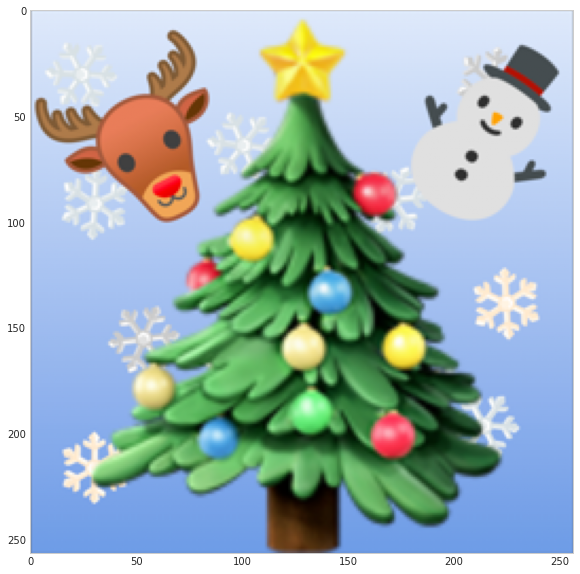

In [2]:
data_dir = Path('/kaggle/input/santa-2022')

image = imread(data_dir / 'image.png')

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image)
ax.grid(None);

# Baseline solution

Solution from [here](https://www.kaggle.com/code/asalhi/tsp-cost-function-start-compress-path-split) using splits. Here, `points_to_path(...)` was the slowest part. Second slowest was `total_cost(...)`.

In [3]:
def get_baseline(image):
    # Generate points
    points_baseline = []
    flag = True
    for split in range(2):
        for i in reversed(range(257)) if split%2==0 else range(257):
            if not flag:
                for j in range(128*split, 128+129*split):
                    points_baseline.append((j-128,i-128))
            else:
                for j in reversed(range(128*split, 128+129*split)):
                    points_baseline.append((j-128,i-128))
            flag = not flag
        flag = False
    points_baseline = np.array(points_baseline)

    # Make path
    path_baseline = points_to_path(points_baseline)

    # Compute cost
    score_baseline = total_cost(path_baseline, image)

    return points_baseline, path_baseline, score_baseline

Let's run this first time and measure how fast it is:

In [4]:
%%time
_ = get_baseline(image)

CPU times: user 12.1 s, sys: 108 ms, total: 12.2 s
Wall time: 12.2 s


**12 seconds** is pretty slow. But what if we run it the second time?

In [5]:
%%time
_ = get_baseline(image)

CPU times: user 1.98 s, sys: 22.9 ms, total: 2 s
Wall time: 2 s


Now it is **~2 seconds**. Why?

First time was slow because `numba` compiles all the functions decorated with `nubma.njit` the first time they are called. All subsequent calls will be much faster. And also faster then pure python functions.

In the [notebook I took it from](https://www.kaggle.com/code/asalhi/tsp-cost-function-start-compress-path-split) only generating the path took **12 seconds**. Here, both generating path and computing total cost was **6 times faster**.

In [6]:
points_baseline, path_baseline, score_baseline = get_baseline(image)

print("Num points:", len(points_baseline))
print("Num configurations:", len(path_baseline))
print("Score:", score_baseline)

Num points: 66049
Num configurations: 66947
Score: 81875.21630640663


# Visualize solution

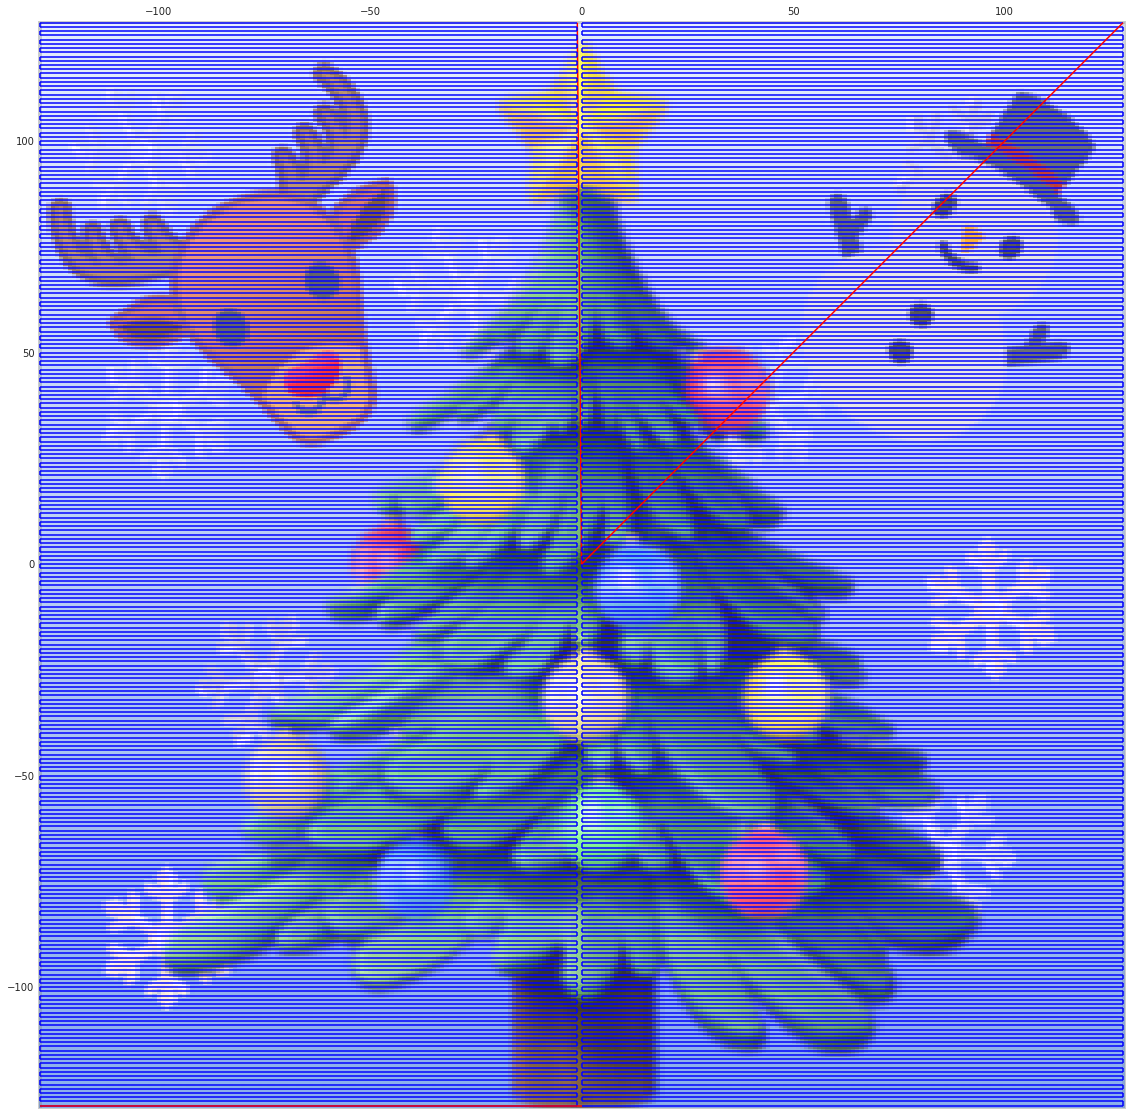

In [7]:
plot_traj(points_baseline, image)

**Red line** at the bottom shows where solution "teleports" too far. Usually we want as little red lines as possible.

# Can there be better baseline?

In the solution above we see 3 red lines. Maybe we can make a solution without red lines at all? I made one:

Score: 82196.31112462115


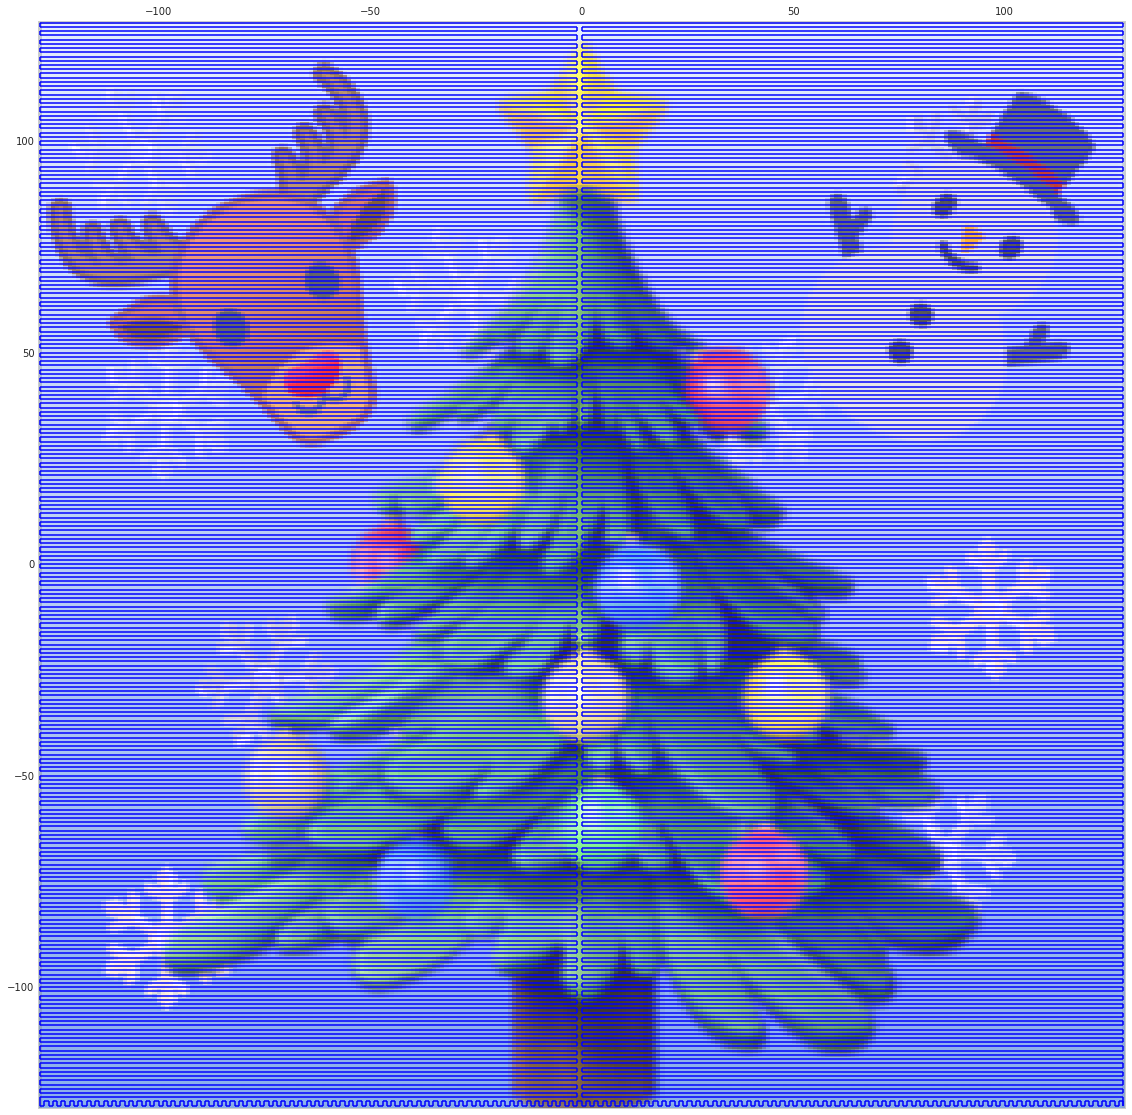

In [8]:
def get_better_baseline(image):
    # Generate points
    points = []
    radius = image.shape[0] // 2
    snaking_margin = 2
    # Go up on the right side
    flag = True
    for y in range(1, radius + 1):
        rng = range(0, radius + 1)
        rng = rng if flag else reversed(rng)
        for x in rng:
            points.append((x, y))
        flag = not flag
    # Go down on the left side
    flag = True
    for y in range(radius, -radius - 1 + snaking_margin, -1):
        rng = range(-1, -radius - 1, -1)
        rng = rng if flag else reversed(rng)
        for x in rng:
            points.append((x, y))
        flag = not flag
    # Go right like snake on the bottom side
    flag = True
    for x in range(-radius, radius + 1):
        rng = range(-radius + snaking_margin - 1, -radius - 1, -1)
        rng = rng if flag else reversed(rng)
        for y in rng:
            points.append((x, y))
        flag = not flag
    # Go up on the right side
    flag = False
    for y in range(-radius + snaking_margin, 1):
        rng = range(0, radius + 1)
        rng = rng if flag else reversed(rng)
        for x in rng:
            points.append((x, y))
        flag = not flag

    points = np.array(points)

    # Make path
    path = points_to_path(points)

    # Compute cost
    score = total_cost(path, image)

    return points, path, score


points_better, path_better, score_better = get_better_baseline(image)
print("Score:", score_better)
plot_traj(points_better, image)

It starts from the center and returns to the center, so no teleports needed.

Unfortunately, this solution scored worse. I think this is because arm movements were more complicated for this one.

So, shorter path does not always make for better solution.

## What can other solutions look like?

Here is one of my solutions for this competition.

I'm not sharing the code for it (just yet :)).

It is worse than the baseline (score about 85k) but it looks cool so I want to show it.

**Andvantages:**
* It takes colors into account
* Tries to avoid singularities in robotic arm movement (small square around the center, about half the size of whole image)
* Uses baseline solution as reference

**Downsides:**
* A lot of long movements (red lines)

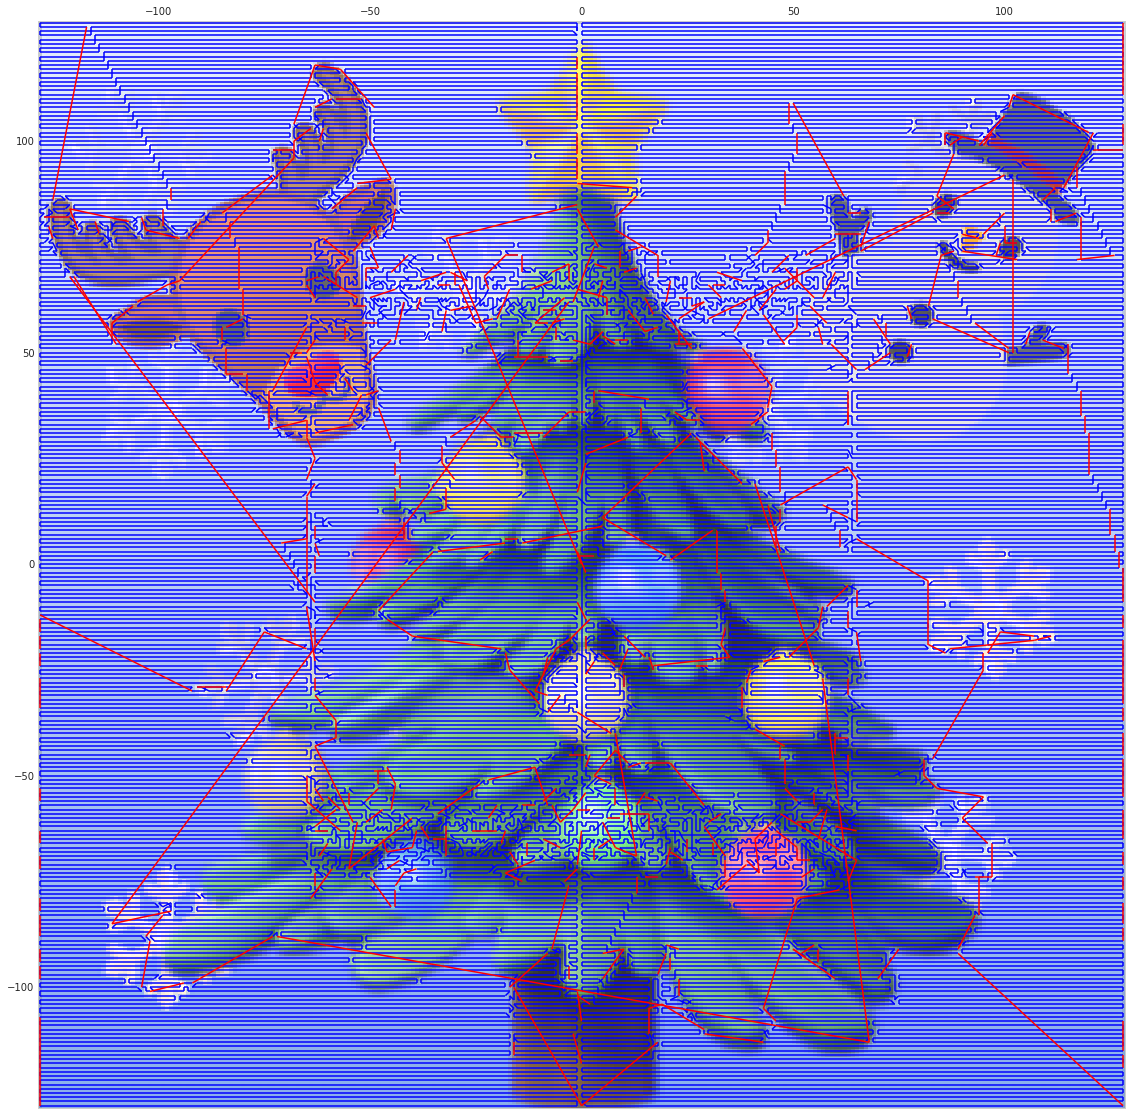

In [9]:
posible_solution_points = np.load('/kaggle/input/santa-2022-possible-solution/posible_solution_points.npy')
plot_traj(posible_solution_points, image)

## Save baseline solution
So, the first solution in this notebook is still best (unfortunately). Let's save it:

In [10]:
def config_to_string(config):
    return ';'.join([' '.join(map(str, vector)) for vector in config])

In [11]:
submission = pd.Series(
    [config_to_string(config) for config in path_baseline],
    name="configuration",
)
submission.to_csv('submission_baseline.csv', index=False)
submission.head()

0    64 0;-32 0;-16 0;-8 0;-4 0;-2 0;-1 0;-1 0
1    64 1;-32 1;-16 1;-8 1;-4 1;-2 1;-1 1;-1 1
2    64 2;-32 2;-16 2;-8 2;-4 2;-2 2;-1 1;-1 1
3    64 3;-32 3;-16 3;-8 3;-4 3;-2 2;-1 1;-1 1
4    64 4;-32 4;-16 4;-8 4;-4 4;-2 2;-1 1;-1 1
Name: configuration, dtype: object